This notebook demonstate the EDA and prepare the data for modeling.

**Problem Statement**


**Goal**

**Hypothesis/Expectations**

In [1]:
#load libraries
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
pd.set_option('display.float_format', lambda x: '%.3f' % x)


#Data profiling/EDA 
import pandas_profiling 



import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

In [2]:
pd.set_option('max_rows', 500) # default is 60 rows
pd.set_option('max_columns', 500) # default is 20 columns
import warnings
warnings.filterwarnings("ignore")
import os,sys

In [3]:
#importing custom library functions
# check at https://github.com/ved93/neo
from neo import visualize, eda, feature_engineering

In [5]:
#to get plotly type plot using df.plot method 
#https://plotly.com/python/pandas-backend/
# pd.options.plotting.backend = "plotly"

In [ ]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [6]:
os.getcwd()

'/Users/vedprakash/Downloads/ds_analysis_template'

In [23]:
df = pd.read_csv("/Users/vedprakash/Downloads/DS Test/Training/X_train.csv")

In [24]:
df.columns = df.columns.str.lower()

In [42]:
TASK = 'clf' #'reg'

In [28]:
df.head()

,unique_id,c1,c2,c3,c4,c5,c6,c7,c8,n1,n2,n4,n5,n6,n7,n8,n9,n10,n10.1,n11,n12,n14,n15,n16,n17,n18,n19,n20,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30,n31,n32,n33,n34,n35,target
0,Candidate_5926,1,0,11,31,0,False,0,True,23.750,nan,nan,nan,2.595,10.000,0,0,2.000,14.000,nan,nan,nan,0.000,nan,nan,nan,nan,nan,nan,nan,27.816,1750.000,nan,nan,nan,nan,nan,nan,nan,nan,58.000,113.390,12.000,2.500
1,Candidate_48134,1,4,2,66,2,False,1,True,11.050,22.000,16.000,12.000,3.795,19.000,4,72,0.000,5.000,9.000,0.000,0.000,0.000,0.000,1944.000,0.060,25856.000,17.000,0.880,1.000,40.000,10833.333,nan,nan,nan,nan,nan,nan,nan,nan,160.000,262.100,17.000,3.700
2,Candidate_51717,1,0,19,2,0,False,0,True,29.000,nan,nan,nan,2.495,17.000,2,15,7.000,3.000,19.000,nan,10.000,1.000,nan,nan,nan,nan,nan,nan,nan,20.000,6250.000,nan,nan,nan,nan,nan,nan,nan,nan,24.000,50.290,18.000,2.400
3,Candidate_26401,1,1,16,47,1,False,4,True,17.990,1.000,4.000,4.000,3.595,6.000,5,190,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8244.000,0.890,1006.000,6.000,1.000,0.000,26.000,2413.667,nan,nan,nan,nan,nan,nan,nan,nan,70.000,126.520,27.000,3.500
4,Candidate_34872,1,1,13,1,1,True,6,True,27.500,206.000,11.000,11.000,3.895,31.000,10,1504,0.000,1.000,4.000,0.000,0.000,0.000,0.000,57532.000,0.970,3398.000,31.000,0.960,0.000,44.000,7666.667,nan,nan,nan,nan,nan,nan,nan,nan,100.000,205.470,21.000,3.800


In [27]:
#rename the target var
df['target'] = df['n3']
df.drop(['n3'],axis = 1, inplace = True)

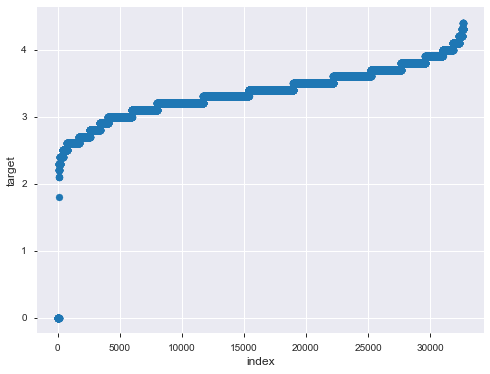

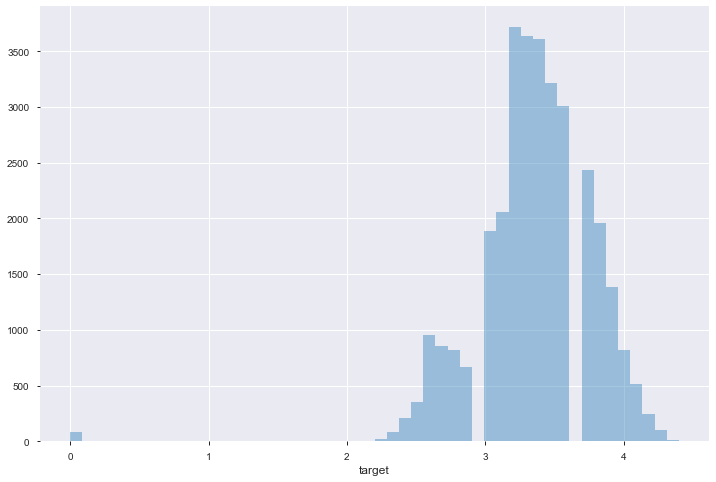

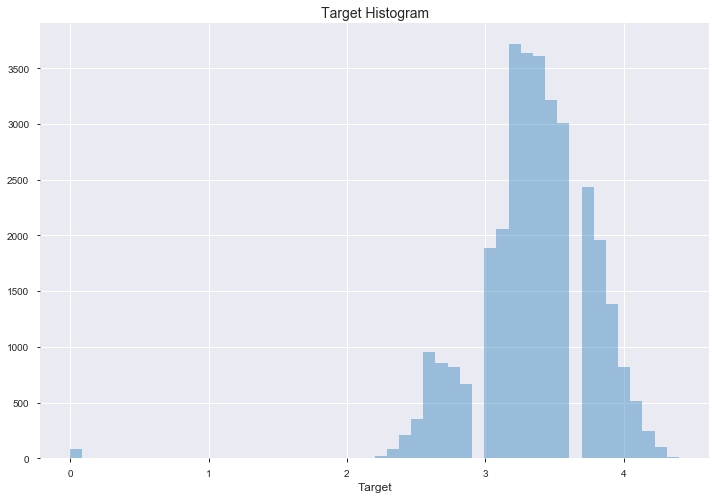

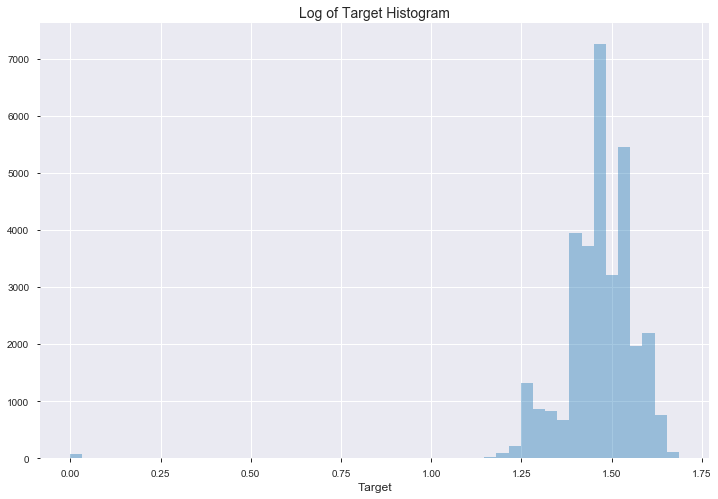

target Quantiles:
0.000   0.000
0.010   2.400
0.025   2.600
0.100   2.800
0.250   3.200
0.500   3.400
0.750   3.600
0.900   3.800
0.950   4.000
0.975   4.100
0.990   4.200
1.000   4.400
Name: target, dtype: float64


In [32]:
#explore the target var
if len(df.target.unique()) < 5:
    temp = df.target.value_counts()

    df = pd.DataFrame({'labels': temp.index,
                       'values': temp.values
                      })


    # fig = px.pie(df, values='values', title='Class Distribution',labels='labels')
    fig = df.iplot(kind='pie',labels='labels',values='values', title='Target Class Distribution',
                  dimensions = (400,300)
                  )    
else:
    #try this if error -- , kde_kws={'bw': 0.1}
#     visualize.density_plot(df , 'target' )

    plt.figure(figsize=(8,6))
    plt.scatter(range(df.shape[0]), np.sort(df.target.values))
    plt.xlabel('index', fontsize=12)
    plt.ylabel('target', fontsize=12)
    plt.show()

    #if there are outliers then do followiung
    ulimit = np.percentile(df.target.values, 99)
    llimit = np.percentile(df.target.values, 1)
    df['target'].loc[df['target']>ulimit] = ulimit
    df['target'].loc[df['target']<llimit] = llimit

    plt.figure(figsize=(12,8))
    sns.distplot(df.target.values, bins=50, kde=False)
    plt.xlabel('target', fontsize=12)
    plt.show()


    plt.figure(figsize=(12,8))
    sns.distplot(df["target"].values, bins=50, kde=False)
    # sns.distplot(dfpro.req_next_30.values, hist_kws={'alpha': 0.9}, kde=False)
    plt.xlabel('Target', fontsize=12)
    plt.title("Target Histogram", fontsize=14)
    plt.show()



    #log of target var
    #reference -https://www.kaggle.com/sudalairajkumar/simple-exploration-baseline-santander-value
    plt.figure(figsize=(12,8))
    sns.distplot( np.log1p(df["target"].values), bins=50, kde=False)
    plt.xlabel('Target', fontsize=12)
    plt.title("Log of Target Histogram", fontsize=14)
    plt.show()
    
    
    eda.print_quantiles(df, 'target')


In [38]:
# eda.gen_eda(df)

In [40]:
# eda.general_stats(df)

In [ ]:
eda.create_summary_report(df)

In [41]:
# dfmissing=check_missing_data(df)

# dfmissing

# col_high_missing = [col for col in dfmissing.columns if dfmissing.loc['Percent',col] > 90 ]

# len(col_high_missing)

# # We will remove variables with 90% missing values. This is fair assumption to remove but we will revisit it again if we dont see any performance. These missing values might contains some info

# dfnonmissing = df.loc[:,~df.columns.isin(col_high_missing)]  

### Basic Observations from Summary

In [52]:
df.head()

,unique_id,c1,c2,c3,c4,c5,c6,c7,c8,n1,n2,n4,n5,n6,n7,n8,n9,n10,n10.1,n11,n12,n14,n15,n16,n17,n18,n19,n20,n21,n22,n23,n24,n25,n26,n27,n28,n29,n30,n31,n32,n33,n34,n35,target
0,Candidate_5926,1,0,11,31,0,False,0,True,23.750,nan,nan,nan,2.595,10.000,0,0,2.000,14.000,nan,nan,nan,0.000,nan,nan,nan,nan,nan,nan,nan,27.816,1750.000,nan,nan,nan,nan,nan,nan,nan,nan,58.000,113.390,12.000,2.500
1,Candidate_48134,1,4,2,66,2,False,1,True,11.050,22.000,16.000,12.000,3.795,19.000,4,72,0.000,5.000,9.000,0.000,0.000,0.000,0.000,1944.000,0.060,25856.000,17.000,0.880,1.000,40.000,10833.333,nan,nan,nan,nan,nan,nan,nan,nan,160.000,262.100,17.000,3.700
2,Candidate_51717,1,0,19,2,0,False,0,True,29.000,nan,nan,nan,2.495,17.000,2,15,7.000,3.000,19.000,nan,10.000,1.000,nan,nan,nan,nan,nan,nan,nan,20.000,6250.000,nan,nan,nan,nan,nan,nan,nan,nan,24.000,50.290,18.000,2.400
3,Candidate_26401,1,1,16,47,1,False,4,True,17.990,1.000,4.000,4.000,3.595,6.000,5,190,0.000,0.000,0.000,0.000,0.000,0.000,0.000,8244.000,0.890,1006.000,6.000,1.000,0.000,26.000,2413.667,nan,nan,nan,nan,nan,nan,nan,nan,70.000,126.520,27.000,3.500
4,Candidate_34872,1,1,13,1,1,True,6,True,27.500,206.000,11.000,11.000,3.895,31.000,10,1504,0.000,1.000,4.000,0.000,0.000,0.000,0.000,57532.000,0.970,3398.000,31.000,0.960,0.000,44.000,7666.667,nan,nan,nan,nan,nan,nan,nan,nan,100.000,205.470,21.000,3.800


In [ ]:
cat_cols =list(col for col in df.select_dtypes('object').columns if col not in ['appointmentId'])
num_cols = list(col for col in df.select_dtypes(['int64','float64']).columns if col not in ['appointmentId'])

In [51]:
if TASK == 'reg':
    # lets check correlation

    from scipy.stats import spearmanr
    import warnings
    warnings.filterwarnings("ignore")



    #let us first take the 'float' variables alone
    # and then get the correlation with the target variable to see how they are related.
    # Let us just impute the missing values with mean values to compute correlation coefficients #
    mean_values = df.mean(axis=0)
    train_df_new = df.fillna(mean_values )

    # Now let us look at the correlation coefficient of each of these variables #
    #logerror is the target var
    x_cols = [col for col in train_df_new.columns if col not in ['target','unique_id'] if 'n' in col]


    labels = []
    values = []
    for col in x_cols:
        labels.append(col)
        values.append(np.corrcoef(train_df_new[col].values, train_df_new.target.values)[0,1])
    corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
    corr_df = corr_df.sort_values(by='corr_values')
    print(corr_df)

    ind = np.arange(len(labels))
    width = 0.9
    fig, ax = plt.subplots(figsize=(12,10))
    rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
    ax.set_yticks(ind)
    ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
    ax.set_xlabel("Correlation coefficient")
    ax.set_title("Correlation coefficient of the variables")
    #autolabel(rects)
    plt.show()



In [ ]:
#check zero corr coef var
corr_zero_cols = ['N9','N2','N17','N29']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))


#correlation among features
cols_to_use = corr_df.col_labels.tolist()

temp_df = df[cols_to_use]
corrmat = temp_df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1., square=True)
plt.title("Important variables correlation map", fontsize=15)
plt.show()



In [56]:
mean_values = df.mean(axis=0)
train_df_new = df.fillna(mean_values )
x_cols = [col for col in train_df_new.columns if col not in ['target','unique_id'] if 'n' in col]


['n1', 'n2', 'n4', 'n5', 'n6', 'n7']

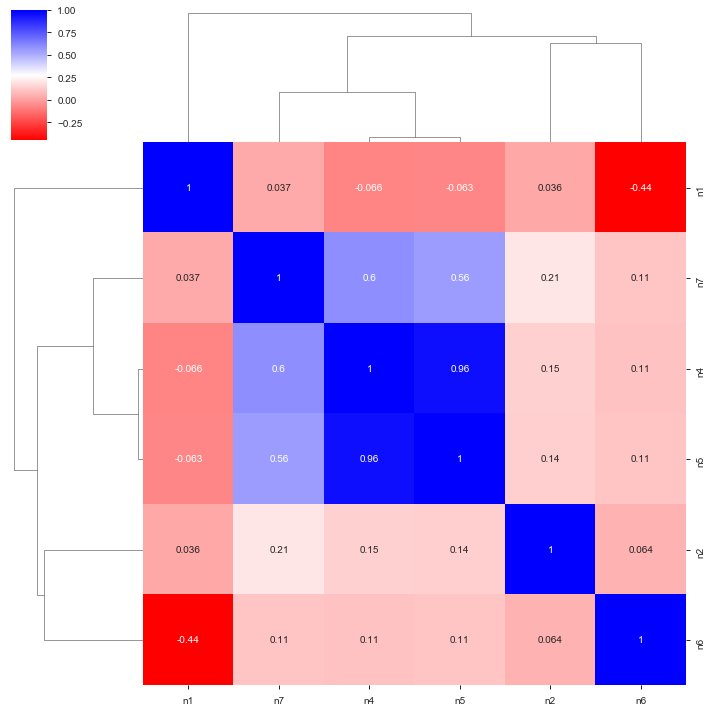

In [59]:
# This is pearson correlation
# # plot correlation, annmotate with values
sns.clustermap(train_df_new[x_cols[:6]].corr(), annot=True, cmap='bwr_r')

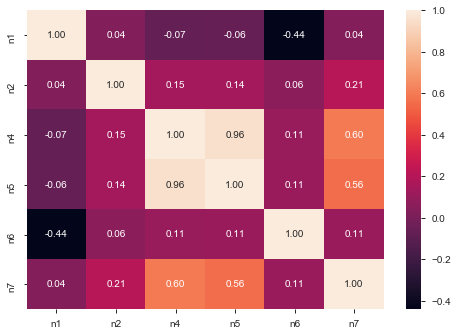

In [60]:

#Correlation analysis
sns.heatmap(train_df_new[x_cols[:6]].corr(), annot=True, fmt='.2f')
correlations = df.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

In [ ]:
corr_matrix = temp_df.corr().abs()

# Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# upper  #.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)




# high_corr_var=np.where(corr_matrix>0.8)
# high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
# high_corr_var


# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

In [ ]:
del train_df_new, temp_df

In [ ]:
check_missing_data(df) 

In [ ]:
var_missing_more_than_80pct = ['N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32']

features_to_drop = to_drop+ corr_zero_cols+var_missing_more_than_80pct + ['Unique_ID']

#select only unqiue vars
features_to_drop = list(set(features_to_drop))

### Basic Feature Engineering

In [ ]:
feature_engineering.add_datepart(dfmerged, 'date')

In [ ]:
# df = pd.read_feather('dfv1')

### Hypothesis Validation

#### 1.1 

### EDA v2

In [ ]:
if TASK == 'clf':    

In [ ]:
sns.pairplot(iris_data.dropna() )

In [ ]:
# We have to temporarily drop the rows with 'NA' values
# because the Seaborn plotting function does not know
# what to do with them
sns.pairplot(iris_data.dropna(), hue='class')
;

### Testing our data

In [ ]:

# We know that we should only have three classes
assert len(iris_data_clean['class'].unique()) == 3

In [ ]:

# We know that sepal lengths for 'Iris-versicolor' should never be below 2.5 cm
assert iris_data_clean.loc[iris_data_clean['class'] == 'Iris-versicolor', 'sepal_length_cm'].min() >= 2.5

In [ ]:
# We know that our data set should have no missing measurements
assert len(iris_data_clean.loc[(iris_data_clean['sepal_length_cm'].isnull()) |
                               (iris_data_clean['sepal_width_cm'].isnull()) |
                               (iris_data_clean['petal_length_cm'].isnull()) |
                               (iris_data_clean['petal_width_cm'].isnull())]) == 0

In [ ]:
# generate count statistics of duplicate entries
if len(df[df.duplicated()]) > 0:
    print("\n***Number of duplicated entries: ", len(df[df.duplicated()]))
    display(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
    print("\nNo duplicated entries found")

In [ ]:
df.to_feather('dfv1')

### [Optional] Outlier Treatmentment(If you are training linear models)

### [Optional] Missing Value Treatmentment 

In [ ]:

# 'Saving Account'

credit['Saving accounts']= credit['Saving accounts'].map({'little': 'little', 'moderate': 'moderate', 'quite rich':'other','rich':'other', 'NA':'other' })

In [ ]:

#Encode categorical variables
#Encoding for target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['categorical_var'] = le.fit_transform(df['categorical_var'])
#One hot encoding for categorical information
#Use sklearn's OneHotEncoder for categories encoded as possitive real numbers
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
df['var_to_encode'] = enc.fit_transform(df['var_to_encode'])
#Use pandas get_dummies for categories encoded as strings
pd.get_dummies(df, columns=['col1','col2'])

In [ ]:
#stole from https://github.com/albertsl/toolkit/blob/master/templates/Data%20Science%20Template.ipynb

In [ ]:
#Feature engineering. Create new features by transforming the data
#Discretize continuous features
#Decompose features (categorical, date/time, etc.)
#Add promising transformations of features (e.g., log(x), sqrt(x), x^2, etc.)
#Aggregate features into promising new features (x*y)
#For speed/movement data, add vectorial features. Try many different combinations
df['position_norm'] = df['position_X'] ** 2 + df['position_Y'] ** 2 + df['position_Z'] ** 2
df['position_module'] = df['position_norm'] ** 0.5
df['position_norm_X'] = df['position_X'] / df['position_module']
df['position_norm_Y'] = df['position_Y'] / df['position_module']
df['position_norm_Z'] = df['position_Z'] / df['position_module']
df['position_over_velocity'] = df['position_module'] / df['velocity_module']
#For time series data: Discretize the data by different samples.
from astropy.stats import median_absolute_deviation
from statsmodels.robust.scale import mad
from scipy.stats import kurtosis
from scipy.stats import skew

def CPT5(x):
    den = len(x)*np.exp(np.std(x))
    return sum(np.exp(x))/den

def SSC(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x, x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    #xn+1
    xn_i1 = x[0:len(x)-2]  #xn-1
    ans = np.heaviside((xn-xn_i1)*(xn-xn_i2), 0)
    return sum(ans[1:])

def wave_length(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x, x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    #xn+1
    return sum(abs(xn_i2-xn))

def norm_entropy(x):
    tresh = 3
    return sum(np.power(abs(x), tresh))

def SRAV(x):
    SRA = sum(np.sqrt(abs(x)))
    return np.power(SRA/len(x), 2)

def mean_abs(x):
    return sum(abs(x))/len(x)

def zero_crossing(x):
    x = np.array(x)
    x = np.append(x[-1], x)
    x = np.append(x, x[1])
    xn = x[1:len(x)-1]
    xn_i2 = x[2:len(x)]    #xn+1
    return sum(np.heaviside(-xn*xn_i2, 0))

df_tmp = pd.DataFrame()
for column in tqdm(df.columns):
    df_tmp[column + '_mean'] = df.groupby(['series_id'])[column].mean()
    df_tmp[column + '_median'] = df.groupby(['series_id'])[column].median()
    df_tmp[column + '_max'] = df.groupby(['series_id'])[column].max()
    df_tmp[column + '_min'] = df.groupby(['series_id'])[column].min()
    df_tmp[column + '_std'] = df.groupby(['series_id'])[column].std()
    df_tmp[column + '_range'] = df_tmp[column + '_max'] - df_tmp[column + '_min']
    df_tmp[column + '_max_over_Min'] = df_tmp[column + '_max'] / df_tmp[column + '_min']
    df_tmp[column + 'median_abs_dev'] = df.groupby(['series_id'])[column].mad()
    df_tmp[column + '_mean_abs_chg'] = df.groupby(['series_id'])[column].apply(lambda x: np.mean(np.abs(np.diff(x))))
    df_tmp[column + '_mean_change_of_abs_change'] = df.groupby('series_id')[column].apply(lambda x: np.mean(np.diff(np.abs(np.diff(x)))))
    df_tmp[column + '_abs_max'] = df.groupby(['series_id'])[column].apply(lambda x: np.max(np.abs(x)))
    df_tmp[column + '_abs_min'] = df.groupby(['series_id'])[column].apply(lambda x: np.min(np.abs(x)))
    df_tmp[column + '_abs_avg'] = (df_tmp[column + '_abs_min'] + df_tmp[column + '_abs_max'])/2
    df_tmp[column + '_abs_mean'] = df.groupby('series_id')[column].apply(lambda x: np.mean(np.abs(x)))
    df_tmp[column + '_abs_std'] = df.groupby('series_id')[column].apply(lambda x: np.std(np.abs(x)))
    df_tmp[column + '_abs_range'] = df_tmp[column + '_abs_max'] - df_tmp[column + '_abs_min']
    df_tmp[column + '_skew'] = df.groupby(['series_id'])[column].skew()
    df_tmp[column + '_q25'] = df.groupby(['series_id'])[column].quantile(0.25)
    df_tmp[column + '_q75'] = df.groupby(['series_id'])[column].quantile(0.75)
    df_tmp[column + '_q95'] = df.groupby(['series_id'])[column].quantile(0.95)
    df_tmp[column + '_iqr'] = df_tmp[column + '_q75'] - df_tmp[column + '_q25']
    df_tmp[column + '_CPT5'] = df.groupby(['series_id'])[column].apply(CPT5)
    df_tmp[column + '_SSC'] = df.groupby(['series_id'])[column].apply(SSC)
    df_tmp[column + '_wave_lenght'] = df.groupby(['series_id'])[column].apply(wave_length)
    df_tmp[column + '_norm_entropy'] = df.groupby(['series_id'])[column].apply(norm_entropy)
    df_tmp[column + '_SRAV'] = df.groupby(['series_id'])[column].apply(SRAV)
    df_tmp[column + '_kurtosis'] = df.groupby(['series_id'])[column].apply(kurtosis)
    df_tmp[column + '_zero_crossing'] = df.groupby(['series_id'])[column].apply(zero_crossing)
    df_tmp[column +  '_unq'] = df[column].round(3).nunique()
    try:
        df_tmp[column + '_freq'] = df[column].value_counts().idxmax()
    except:
        df_tmp[column + '_freq'] = 0
    df_tmp[column + '_max_freq'] = df[df[column] == df[column].max()].shape[0]
    df_tmp[column + '_min_freq'] = df[df[column] == df[column].min()].shape[0]
    df_tmp[column + '_pos_freq'] = df[df[column] >= 0].shape[0]
    df_tmp[column + '_neg_freq'] = df[df[column] < 0].shape[0]
    df_tmp[column + '_nzeros'] = (df[column]==0).sum(axis=0)
df = df_tmp.copy()
#Create a new column from conditions on other columns
df['column_y'] = df[(df['column_x1'] | 'column_x2') & 'column_x3']
df['column_y'] = df['column_y'].apply(bool)
df['column_y'] = df['column_y'].apply(int)
#Create a new True/False column according to the first letter on another column.
lEI = [0] * df.shape[0]

for i, row in df.iterrows():
    try:
        l = df['room_list'].iloc[i].split(', ')
    except:
        #When the given row is empty
        l = []
    for element in l:
        if element[0] == 'E' or element[0] == 'I':
            lEI[i] = 1

df['EI'] = pd.Series(lEI)
